In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
import copy

In [2]:
### Loading images ###
# neural networks from the torch library are trained with tensor values ranging from 0 to 1.
# 所以像素值要从0-255压到0-1
device = torch.device("cpu")

imsize = 256
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_path):
    image = Image.open(image_path)
    # 要添加一个假的batch_size这个dimension
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

### Show image ###
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [3]:
### Loss Functions ###
# Contentloss
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 把target content从dynamical tree上detach下来
        # Otherwise the forward method of the criterion will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Style loss
def gram_matrix(input):
    a, b, c, d = input.size()
    # a是batch_size是1
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t()) 
    
    # normalize
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    

In [4]:
### importing vgg19 ###
cnn = models.vgg19(pretrained=True).features.to(device).eval()

#  VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
#  We will use them to normalize the image before sending it into the network.

cnn_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [5]:
### add content loss and style loss layers immediately after the convolution layer they are detecting.### 
# 计算 style/content losses 的层:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_loss(cnn, norm_mean, norm_std, style_img, content_img,
                      content_layers=content_layers_default,
                      style_layers=style_layers_default):
    # 深拷贝是原对象所有内容都拷贝过来了，修改不会改变对方
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(norm_mean, norm_std).to(device)
    content_losses = []
    style_losses = []
    
    #  assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    
    model = nn.Sequential(normalization)

    i = 0  
    # children()返回的是最外层的元素，modules()返回的是所有的元素，包括不同级别的子元素
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # 根据tutorial，in-place的版本对于content loss和style loss效果不好
            # 所以换成out of place
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # 把loss加到model的最后，最后再从model中取出来（model作为一个sequential，
            # 可以储存在后面，不用新建储存空间
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 把loss后面的model剪掉
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    # 最后得到的就是在对应层后加了loss计算的model，且只有最后一层loss之前的layer
    # 节省了计算空间
    return model, style_losses, content_losses


In [6]:
# training process
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    # 拟牛顿条件
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps,
                       style_weight, content_weight):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_loss(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    print('Optimizing..')
    
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # 把数值转为0-1之间
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item() * style_weight, content_score.item() * content_weight))

            return style_score + content_score

        optimizer.step(closure)
    # 最后也别忘了置回0-1之间
    input_img.data.clamp_(0, 1)

    return input_img

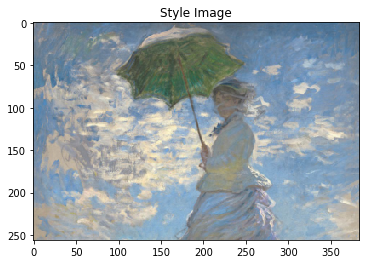

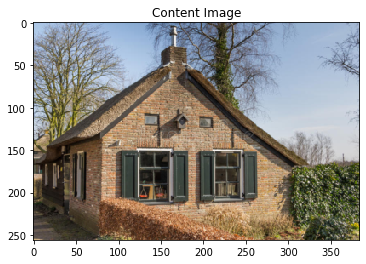

Building the style transfer model..


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Optimizing..
run [50]:
Style Loss : 10.986931 Content Loss: 14.849438
run [100]:
Style Loss : 6.447834 Content Loss: 7.978470
run [150]:
Style Loss : 4.253591 Content Loss: 6.117703
run [200]:
Style Loss : 2.477179 Content Loss: 5.474195
run [250]:
Style Loss : 1.075809 Content Loss: 5.159733
run [300]:
Style Loss : 0.686328 Content Loss: 4.849302


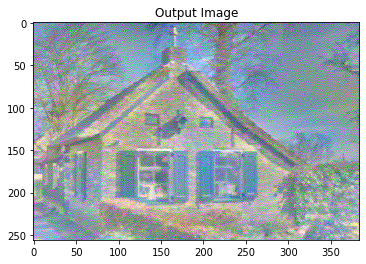

In [11]:
style_img = image_loader("./Monet.jpg")
content_img = image_loader("./house.jpg")

# 用白噪声图片作为初始图片，并对这张图片进行gradient descent
input_img = torch.randn(content_img.data.size(), device=device)

num_steps = 300
style_weight = 100000
content_weight = 1

# 打开交互模式
# plt.plot(x)或plt.imshow(x)是直接出图像，不需要plt.show()
plt.ion()
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


output = run_style_transfer(cnn, cnn_norm_mean, cnn_norm_std,content_img,style_img, 
                            input_img, num_steps,style_weight, content_weight)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

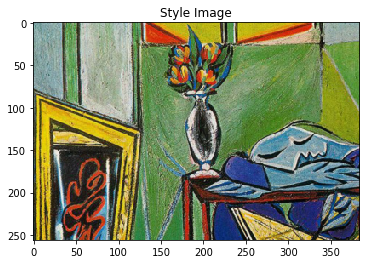

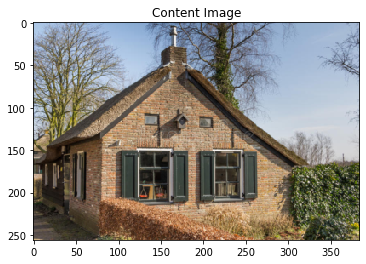

Building the style transfer model..


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Optimizing..
run [50]:
Style Loss : 25.636176 Content Loss: 44.171013
run [100]:
Style Loss : 8.432297 Content Loss: 30.906855
run [150]:
Style Loss : 4.813144 Content Loss: 23.220215
run [200]:
Style Loss : 3.335812 Content Loss: 18.571159
run [250]:
Style Loss : 2.667421 Content Loss: 15.536078
run [300]:
Style Loss : 2.196405 Content Loss: 13.474949


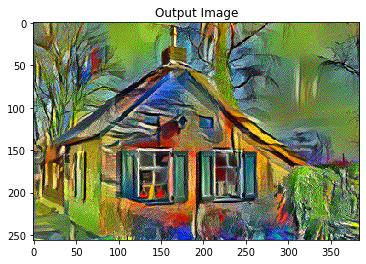

In [14]:
style_img = image_loader("./muse.jpg")
content_img = image_loader("./house.jpg")

input_img = torch.randn(content_img.data.size(), device=device)

num_steps = 300
style_weight = 100000
content_weight = 1

plt.ion()
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


output = run_style_transfer(cnn, cnn_norm_mean, cnn_norm_std,content_img,style_img, 
                            input_img, num_steps,style_weight, content_weight)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

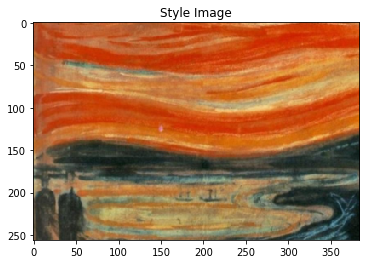

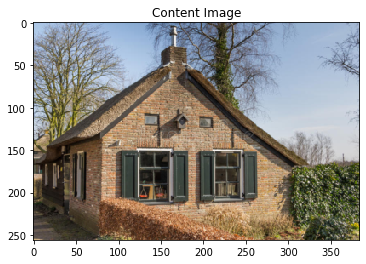

Building the style transfer model..


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Optimizing..
run [50]:
Style Loss : 44.851212 Content Loss: 22.539612
run [100]:
Style Loss : 8.903592 Content Loss: 15.466595
run [150]:
Style Loss : 3.775434 Content Loss: 12.671213
run [200]:
Style Loss : 1.910264 Content Loss: 11.238296
run [250]:
Style Loss : 1.474343 Content Loss: 10.419486
run [300]:
Style Loss : 1.308095 Content Loss: 9.958015


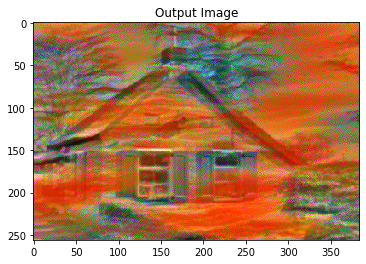

In [15]:
style_img = image_loader("./scream.jpg")
content_img = image_loader("./house.jpg")

input_img = torch.randn(content_img.data.size(), device=device)

num_steps = 300
style_weight = 100000
content_weight = 1

plt.ion()
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


output = run_style_transfer(cnn, cnn_norm_mean, cnn_norm_std,content_img,style_img, 
                            input_img, num_steps,style_weight, content_weight)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()